In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

Updated to use the new datasets (train / test splits)  
Remvoed the extra words to explain what was done 


# Imports

In [2]:
import pandas as pd
import torch
import random

from utils.setup_graph import make_mapping, create_nodes, train_validation_split
from utils.setup_embeddings import instantiate_users, custom_BLaIR_text_embedding_model
# from utils.graph_model import 
from utils.graph_helpers import train_model, plot_loss, final_evaluation
from utils.recomendations import recommend_products, pretty_print_recomendations, paper_evaluation

from datasets import load_dataset

/home/viknesh/.venv_ls/dl_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [3]:
# Direct from the source 
reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
product_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

review_df = reviews_dataset['full'].to_pandas()
product_df = product_dataset.to_pandas()

agg_user_df = pd.read_csv("data/cleaned/user_metadata.csv")
new_product_df = pd.read_csv("data/cleaned/product_metadata.csv")

# Split into train test 

This will eventually be fixed to have a fixed dataset  
Effectively just need to make sure the user product edge list is the constant one 

Right now will also do the sanity checks as well as the rows and the correctness of ids etc 

In [4]:
# Things to remove 
# 1. Users that rate products not in the product df (redundant data)
# 2. Products that do not have a user rating (redundant data)
# 3. Users that will only appear in the test set (basically we want to ensure they have a history)

In [5]:
useful_parent_asin = set(review_df.parent_asin).intersection(set(product_df.parent_asin))

In [6]:
full_review_df = review_df[review_df.parent_asin.isin(useful_parent_asin)].copy()
full_product_df = product_df[product_df.parent_asin.isin(useful_parent_asin)].copy()

In [7]:
full_review_df = full_review_df.drop_duplicates(subset = ["user_id", "parent_asin"]).reset_index(drop = True)

# Two possible options (about 2%)
# .groupby(["user_id", "parent_asin"]).mean().reset_index()
# .drop_duplicates(subset = ["user_id", "parent_asin"]).sort_values(["user_id", "timestamp"]).reset_index(drop = True)

In [8]:
graph_edges = (full_review_df[["user_id", "parent_asin", "timestamp", "rating"]]
               .sort_values(["user_id", "timestamp"])               
               .reset_index(drop = True)
)

In [9]:
# graph_edges_count = graph_edges.user_id.value_counts()
# only_train_edges = graph_edges[graph_edges.user_id.isin(graph_edges_count[graph_edges_count <= 3].reset_index().user_id)].sort_values(["user_id", "timestamp"])
# rest_edges = graph_edges[~graph_edges.user_id.isin(graph_edges_count[graph_edges_count <= 3].reset_index().user_id)].sort_values(["user_id", "timestamp"])

In [10]:
# make the id to idx mapping first to ensure all are accounted for 
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(graph_edges.user_id.unique())}
prod_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(graph_edges.parent_asin.unique())}

In [11]:
graph_edges["user_idx"] = graph_edges.user_id.apply(lambda x: user_id_to_idx[x])
graph_edges["prod_idx"] = graph_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
graph_edges["prod_shift"] = graph_edges.prod_idx + len(user_id_to_idx)
# graph_edges

In [12]:
import numpy as np 

train_mark = np.quantile(graph_edges.timestamp, 0.7)
test_mark = np.quantile(graph_edges.timestamp, 0.85)

In [13]:
train_edges = graph_edges[graph_edges.timestamp <= train_mark].copy()
test_edges = graph_edges[graph_edges.timestamp >= test_mark].copy()
val_edges = graph_edges[(graph_edges.timestamp > train_mark) & (graph_edges.timestamp < test_mark)].copy()

# Making the edges 

In [14]:
train_edge_index = torch.tensor(train_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)
val_edge_index = torch.tensor(val_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)
test_edge_index = torch.tensor(test_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)

In [15]:
train_edge_weights = torch.tensor(train_edges.rating.to_list(), dtype=torch.float)
val_edge_weights = torch.tensor(val_edges.rating.to_list(), dtype=torch.float)
test_edge_weights = torch.tensor(test_edges.rating.to_list(), dtype=torch.float)

# Making the Nodes

In [16]:
prod_numeric = torch.tensor(full_product_df[["average_rating", "rating_number"]].to_numpy(), dtype = torch.float)
# title_features = custom_BLaIR_text_embedding_model(full_product_df["title"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 30) # 1h 30 min 

In [17]:
# product_features = torch.cat([prod_numeric, title_features], dim=1)
product_features = prod_numeric

In [18]:
# meta_features = custom_BLaIR_text_embedding_model(product_node_content_dfa["meta"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 30) # 1h 30 min 
# review_features = custom_BLaIR_text_embedding_model(product_node_content_df["reviews"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 30) # 10 min
# user_review_features = custom_BLaIR_text_embedding_model(user_node_content_df["reviews"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 512) # 1h

# meta_features = torch.load("data/embeddings/meta_features_512.pt")
# review_features = torch.load("data/embeddings/review_features_512.pt")
# user_review_features = torch.load("data/embeddings/user_review_features_512.pt")

In [19]:
# join back i guess
# product_features = torch.cat([meta_features, review_features], dim=1)

In [20]:
# user_features = instantiate_users(agg_user_df, user_review_features) # df intiation
# user_features = instantiate_users(len(user_mapping), 20) # zero initiation

user_features = torch.tensor(agg_user_df.drop(["user_id", "reviews"], axis = 1).to_numpy(), dtype = torch.float) 

# Set up variables

In [21]:
num_users = len(user_id_to_idx)
num_products = len(prod_id_to_idx)
user_feature_dim = user_features.shape[1]
product_feature_dim = product_features.shape[1]

# Move to GPU 

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
val_edge_index = val_edge_index.to(device)
val_edge_weights = val_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)
user_features = user_features.to(device)
product_features = product_features.to(device)

# Run the models

This is a copy paste of the models in the notebooks, no changes to logic.  
Modificiations if made is mainly for the function wrappers or stuff 

Tried batching, but it ended up not being that effective.   
Code works but slow.    
It was written in case not enough memory but guess right now might not be needed - gpu works on full set one shot 

In [167]:
del base_gnn_model_v2
torch.cuda.empty_cache()

In [168]:
from utils.graph_model import BaseGNNRecommender_v2

In [169]:
base_gnn_model_v2 = BaseGNNRecommender_v2(num_users, num_products, user_feature_dim, product_feature_dim, 32)

In [170]:
base_gnn_model_v2.to(device)
train_loss, valid_loss, best_model = train_model(base_gnn_model_v2, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 100, print_progress=True)

Epoch: 10, Train Loss: 2.2690, Val Loss: 2.6503, best model epoch: 10
Epoch: 20, Train Loss: 2.1514, Val Loss: 2.5096, best model epoch: 20
Epoch: 30, Train Loss: 2.0867, Val Loss: 2.4969, best model epoch: 28
Epoch: 40, Train Loss: 2.0409, Val Loss: 2.5033, best model epoch: 36
Epoch: 50, Train Loss: 1.9984, Val Loss: 2.5115, best model epoch: 42
Epoch: 60, Train Loss: 2.0037, Val Loss: 2.5185, best model epoch: 54
Epoch: 70, Train Loss: 1.9197, Val Loss: 2.5556, best model epoch: 54
Epoch: 80, Train Loss: 1.9370, Val Loss: 2.6153, best model epoch: 54
Epoch: 90, Train Loss: 1.7859, Val Loss: 2.5696, best model epoch: 54
Epoch: 100, Train Loss: 1.7605, Val Loss: 2.5789, best model epoch: 97


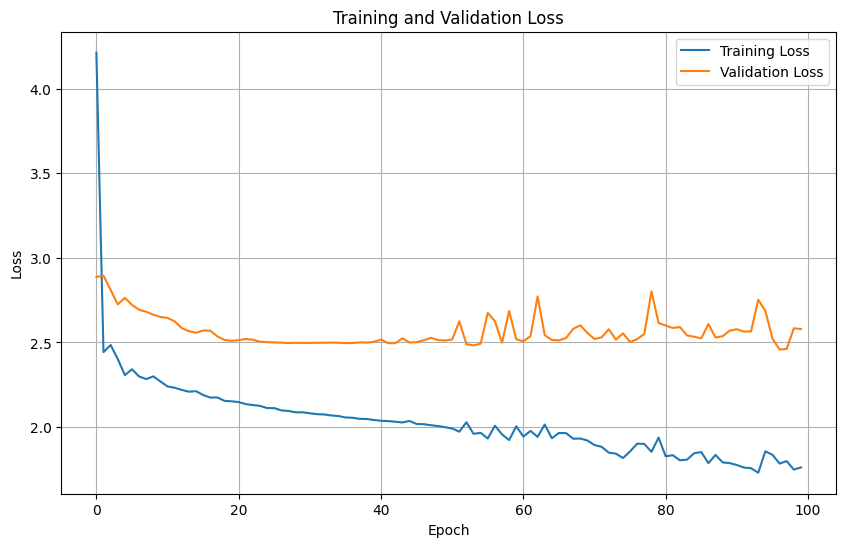

In [171]:
plot_loss(train_loss, valid_loss) # base GNNM

In [172]:
final_evaluation(base_gnn_model_v2, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 2.8163
Best possible loss: 2.6230


# Next recomendations 

Based on the current set up, actually very trash cos the model predicts the exact same stuff (base GNN)  
GNNSAGE not say much better still alternates the same stuff

In [180]:
base_gnn_model_v2.load_state_dict(best_model)

<All keys matched successfully>

In [183]:
user_id = agg_user_df.user_id.sample(1).item()
print(user_id, "\n")
recomendations, preds = recommend_products(base_gnn_model_v2, user_id, user_id_to_idx, prod_id_to_idx,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, full_product_df, "title")
print("\n")

AET5SMKINVXPM37MMSJYNQF4RB5A 

Product 1: Deep Wave 613 Frontal Wig 13X4 Transparent HD Lace Blonde Deep Curly 613 Lace Frontal Wig Human Hair 20inch 613 Human Hair Lace Front Wig with Baby Hair Pre Plucked Free Part 150% Density
Product 2: KISS Catwalk Collection Fake Nails Manicure Kit inspired by Designs from the New York Fashion Shows, Style 'Lights', 24 Glue On Nails in 12 Sizes
Product 3: ABH AmazingBeauty Hair Sun-kissed Double Side Tape Hair Highlight Extensions, Invisible Real Remy Human Hair Skin Weft, 50g 20pcs, Darkest Brown with Chocolate Brown and Chestnut Brown P2-4-6 18 Inch
Product 4: Jeune Marie Ribbon (12 Pack, Mint)
Product 5: Water Wave Bundles with Frontal (14 16 18+14) 365g .Ear to Ear Lace Frontal with Bundles Brazilian Remy Virgin Wet and Wavy Bundles with Frontal Closure Natural Colo
Product 6: EZbobble 24PCS Spiral Hair Ties No Crease, Coil Hair Ties for Women and Girls Plastic Hair Ties Spiral Multicolor Series
Product 7: Acca Kappa White Moss Shampoo & Cond

In [184]:
preds

tensor([1.0164, 1.0082, 1.0294,  ..., 1.0273, 1.0056, 1.0207], device='cuda:0')

# DCG@10 testing 

This section is not from the colab notebook.  
Works to figure out the dcg@10 metric to compare against the paper  

From what i see, we need to be able to pass in some form of sequence into the prection.  
My current understanding is limited on how to tweak it to make it as such.  
Instead perhaps what we can do is to treat the test set as the ground truth label itself   
And then we do the same calcualtions  

In [30]:
# test_edge_index

In [31]:
# user_idx = random.choice(test_edge_index[0]).item()
# actual_prods = test_edge_index[1, test_edge_index[0] == user_idx]
# paper_evaluation(base_gnn_model, user_idx, actual_prods, len(product_mapping), user_features, product_features, top_k=10)

In [32]:
# count = 0 
# for user_idx in test_edge_index[0]:
#     actual_prods = test_edge_index[1, test_edge_index[0] == user_idx]
#     scores = paper_evaluation(base_gnn_model, user_idx, actual_prods, len(product_mapping), user_features, product_features, top_k=10)
#     if scores[0] > 0 or scores[1] > 0:
#         print(user_idx, scores)
#         count += 1
#     if count == 5:
#         break